In [1]:
%pylab inline
import pandas as pd # Pandas for data analysis and manipulation 
from tqdm import tqdm # Module for progress monitoring
tqdm.pandas(desc="progress-bar")
from gensim.models import Doc2Vec
from sklearn import utils
import gensim # Module for word embedding
from gensim.models.doc2vec import TaggedDocument
import re
import numpy as np

Populating the interactive namespace from numpy and matplotlib


## Data Loading and Manipulation

In [2]:
# load data
train_data = pd.read_csv("../input/dataset/train_data.csv")
target = pd.read_csv("../input/dataset/train_target.csv")
test_data = pd.read_csv("../input/dataset/test_data.csv")

# create authors gender dictionary
author_gender = {}
for i in range(len(target)):
    author_gender[target.author[i]] = target.gender[i]
    
# X is the aggregated comments list   
X = []
# the genders
y = []
for author, group in train_data.groupby("author"):
    X.append(group.body.str.cat(sep = " "))
    y.append(author_gender[author])

## Preprocessing, Optimize Input for doc2vec Training

In [3]:
# preprocessing functions
def remove_number(text):
    num = re.compile(r'[-+]?[.\d]*[\d]+[:,.\d]*')
    return num.sub(r'NUMBER', text)

def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'URL',text)

def remove_repeat_punct(text):
    rep = re.compile(r'([!?.]){2,}')
    return rep.sub(r'\1 REPEAT', text)

def remove_elongated_words(text):
    rep = re.compile(r'\b(\S*?)([a-z])\2{2,}\b')
    return rep.sub(r'\1\2 ELONG', text)

def remove_allcaps(text):
    caps = re.compile(r'([^a-z0-9()<>\'`\-]){2,}')
    return caps.sub(r'ALLCAPS', text)

def transcription_smile(text):
    eyes = "[8:=;]"
    nose = "['`\-]"
    smiley = re.compile(r'[8:=;][\'\-]?[)dDp]')
    #smiley = re.compile(r'#{eyes}#{nose}[)d]+|[)d]+#{nose}#{eyes}/i')
    return smiley.sub(r'SMILE', text)

def transcription_sad(text):
    eyes = "[8:=;]"
    nose = "['`\-]"
    smiley = re.compile(r'[8:=;][\'\-]?[(\\/]')
    return smiley.sub(r'SADFACE', text)

def transcription_heart(text):
    heart = re.compile(r'<3')
    return heart.sub(r'HEART', text)

import nltk # lemmatize
import re  # string manipulation
from nltk.stem import WordNetLemmatizer 
from bs4 import BeautifulSoup   
from nltk.corpus import stopwords 
from collections import defaultdict
from nltk.tokenize import word_tokenize
from nltk import pos_tag  # see below
from nltk.corpus import wordnet as wn  # see below
# tags Part of Speech (POS), because the lemmatizer needs it
tag_map = defaultdict(lambda : wn.NOUN)
tag_map['J'] = wn.ADJ
tag_map['V'] = wn.VERB
tag_map['R'] = wn.ADV
# create lemmatizer
word_Lemmatized = WordNetLemmatizer()

def review_to_words1(raw_body):
    # remove html tags
    body_text = BeautifulSoup(raw_body).get_text() 
    #letters_only = re.sub("[^a-zA-Z]", " ", body_text) 
    # lowercase all text
    words = body_text.lower()
    # remove urls
    text = remove_URL(words)
    # remove numbers
    text = remove_number(text)
    # remove smiles
    text = transcription_sad(text)
    text = transcription_smile(text)
    text = transcription_heart(text)
    text = remove_elongated_words(text)
    words = remove_repeat_punct(text)
    # tokenizes and pass to lemmatizer, which lemmatizes taking tags into account (see before)
    words = word_tokenize(words)
    # we don't remove stop words, because doing it on combination with removing the 40 (trial & error estimated parameter) most utilized words (see below) decreases performance
    #stops = set(stopwords.words("english"))                  
    #meaningful_words = [w for w in words if not w in stops]
    Final_words = []
    for word, tag in pos_tag(words):
            word_Final = word_Lemmatized.lemmatize(word,tag_map[tag[0]])
            Final_words.append(word_Final)
    #if len(Final_words)<11: return -1
    # returns lemmatized texts as strings 
    return( " ".join(Final_words))   

In [4]:
from nltk.stem.snowball import SnowballStemmer # stemmer
lemmatizer = WordNetLemmatizer() 
stemmer = SnowballStemmer("english")

# another lemmatizer function. We verified it gives poorer performance
def review_to_words(raw_body):
    body_text = BeautifulSoup(raw_body).get_text() 
    letters_only = re.sub("[^a-zA-Z]", " ", body_text) 
    words = letters_only.lower().split()
    stops = set(stopwords.words("english"))                  
    meaningful_words = [w for w in words if not w in stops]
    final = [lemmatizer.lemmatize(w,pos="v") for w in meaningful_words] 
    #if len(final)<10: return -1
    return( " ".join(final))   

In [5]:
clean_train_comments = [review_to_words1(x) for x in X]

/opt/conda/lib/python3.6/site-packages/bs4/__init__.py:389: UserWarning: "http://mishkanyc.bandcamp.com/album/the-swoup-serengeti" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup


In [6]:
# This function formats the input dor doc2vec
def label_sentences(corpus, label_type):
    labeled = []
    for i, v in enumerate(corpus):
        label = label_type + '_' + str(i)
        labeled.append(TaggedDocument(v.split(), [label]))
    return labeled

In [7]:
y = np.array(y)

In [8]:
from sklearn.model_selection import train_test_split
# splitting
X_train, X_valid, y_train, y_valid = train_test_split(clean_train_comments, y,
                                                      train_size=0.8, test_size=0.2,
                                                      random_state=0)

In [9]:
# createdoc2vec input
X_train = label_sentences(X_train, 'Train')
X_valid = label_sentences(X_valid, 'Valid')
all_data = X_train + X_valid

## doc2vec model definition and training

In [10]:
# define the model
# window: qhow many neighboring words should the moel look at
# negative :som words are negatively weighted
# min_count: once-appearing words are discarded
model_dbow = Doc2Vec(dm=1, vector_size=400, window=7, negative=5, min_count=1, alpha=0.065)
# creates the vocabulary. tdqm is the progress bar
model_dbow.build_vocab([x for x in tqdm(all_data)])
# trianing. The sub doc2vec is trianed an training and test set
for epoch in range(30):
    model_dbow.train(utils.shuffle([x for x in tqdm(all_data)]), total_examples=len(all_data), epochs=1)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha

100%|██████████| 5000/5000 [00:00<00:00, 1171527.85it/s]


In [11]:
# rturns vectorized aggragated texts
def get_vectors(model, corpus_size, vectors_size, vectors_type):
    """
    Get vectors from trained doc2vec model
    :param doc2vec_model: Trained Doc2Vec model
    :param corpus_size: Size of the data
    :param vectors_size: Size of the embedding vectors
    :param vectors_type: Training or Testing vectors
    :return: list of vectors
    """
    vectors = np.zeros((corpus_size, vectors_size))
    for i in range(0, corpus_size):
        prefix = vectors_type + '_' + str(i)
        # builds teh vector extracting it from model.docvecs indexed by label 
        vectors[i] = model.docvecs[prefix]
    return vectors
    
train_vectors_dbow = get_vectors(model_dbow, len(X_train), 400, 'Train')
valid_vectors_dbow = get_vectors(model_dbow, len(X_valid), 400, 'Valid')

## Train data TruncatedSVD visualization

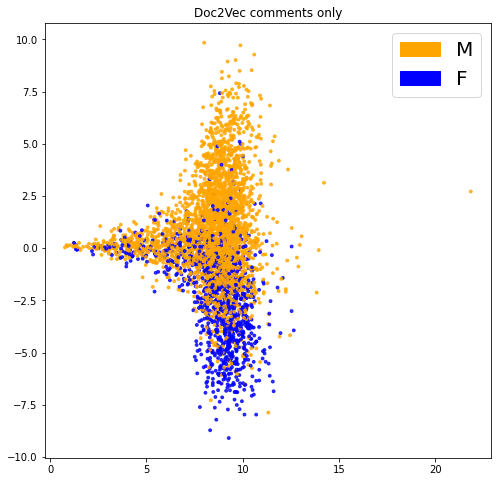

In [12]:
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

# plot along the two dimensions with most variance
def plot_LSA(test_data, test_labels, savepath="PCA_demo.csv", plot=True):
        lsa = TruncatedSVD(n_components=2)
        lsa.fit(test_data)
        lsa_scores = lsa.transform(test_data)
        color_mapper = {label:idx for idx,label in enumerate(set(test_labels))}
        color_column = [color_mapper[label] for label in test_labels]
        colors = ['orange','blue']
        if plot:
            plt.scatter(lsa_scores[:,0], lsa_scores[:,1], s=8, alpha=.8, c=test_labels, cmap=matplotlib.colors.ListedColormap(colors))
            orange_patch = mpatches.Patch(color='orange', label='M')
            blue_patch = mpatches.Patch(color='blue', label='F')
            plt.legend(handles=[orange_patch, blue_patch], prop={'size': 20})
            plt.title('Doc2Vec comments only')
            plt.savefig('foo.pdf')

fig = plt.figure(figsize=(8, 8))          
plot_LSA(train_vectors_dbow,y_train)
plt.show()

## Classifier model definition and validation

In [13]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
# cMLP
mlpClf = MLPClassifier(solver = 'adam', activation= 'relu' ,alpha = 0.0005, verbose = True, early_stopping = True,
                         learning_rate = 'invscaling', max_iter = 400,random_state=0)
        
# K fold (cross validation)
kf = KFold(n_splits = 10)

# training and validation on all subsets
results = cross_val_score(mlpClf, np.concatenate((train_vectors_dbow, valid_vectors_dbow)), np.concatenate((y_train , y_valid)), cv=kf, scoring='roc_auc')
print("roc = ", np.mean(results))

# final fitting
mlpClf.fit(train_vectors_dbow, y_train)

Iteration 1, loss = 0.56958243
Validation score: 0.808889
Iteration 2, loss = 0.36040855
Validation score: 0.844444
Iteration 3, loss = 0.30998915
Validation score: 0.853333
Iteration 4, loss = 0.28063793
Validation score: 0.860000
Iteration 5, loss = 0.25850715
Validation score: 0.864444
Iteration 6, loss = 0.23840169
Validation score: 0.866667
Iteration 7, loss = 0.22138692
Validation score: 0.862222
Iteration 8, loss = 0.20454064
Validation score: 0.860000
Iteration 9, loss = 0.19006128
Validation score: 0.860000
Iteration 10, loss = 0.17641583
Validation score: 0.864444
Iteration 11, loss = 0.16399645
Validation score: 0.862222
Iteration 12, loss = 0.15218209
Validation score: 0.855556
Iteration 13, loss = 0.14028842
Validation score: 0.853333
Iteration 14, loss = 0.13104089
Validation score: 0.857778
Iteration 15, loss = 0.12130565
Validation score: 0.851111
Iteration 16, loss = 0.11260562
Validation score: 0.853333
Iteration 17, loss = 0.10522444
Validation score: 0.844444
Valida

MLPClassifier(activation='relu', alpha=0.0005, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=True, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='invscaling',
              learning_rate_init=0.001, max_fun=15000, max_iter=400,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=0, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=True,
              warm_start=False)

In [14]:
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
# let's also try XGBoost (but MLP performs better)
my_model1 = XGBRegressor(objective = "reg:logistic",n_estimators=10000, learning_rate=0.01, n_jobs=4,subsample = 0.9,
                       min_child_weight = 1,max_depth=4,gamma=1.5,colsample_bytree=0.6,random_state=0)

# K fold (cross validation)
kf = KFold(n_splits = 10)

# training and validation on all subsets
results = cross_val_score(my_model1, np.concatenate((train_vectors_dbow, valid_vectors_dbow)), np.concatenate((y_train , y_valid)), cv=kf, scoring='roc_auc')
print("roc = ", np.mean(results))


my_model1.fit(train_vectors_dbow, y_train, 
             early_stopping_rounds=80,
             #sample_weight = w,
             eval_set=[(valid_vectors_dbow, y_valid)],
             verbose=False)

roc =  0.8786039820642507


XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.6, gamma=1.5, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.01, max_delta_step=0, max_depth=4,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=10000, n_jobs=4, num_parallel_tree=1,
             objective='reg:logistic', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=0.9, tree_method=None,
             validate_parameters=False, verbosity=None)

In [15]:
# in the fit function there is the early stop, that one may set iff there is a validation set. The early stop interrupts the training when themodel starts overfitting. But, the model that will predict the test will have no validation during training, so we get here a value and heuristicallly use it also when predicting test
print(my_model1.best_iteration)

2153


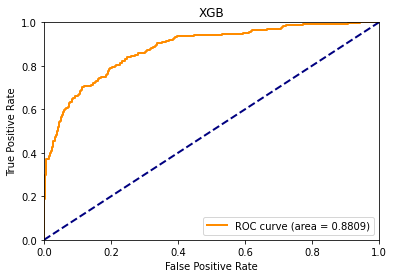

In [16]:
# roc plot
y_score = my_model1.predict(valid_vectors_dbow)
# Roc Curve for validation data 
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_valid, y_score)
roc_auc = auc(fpr, tpr) 

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.4f)'% roc_auc )

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('XGB')
plt.legend(loc="lower right")
plt.show()

In [17]:
# save XGB predictions
np.save("../working/y_scoremXGB",y_score)

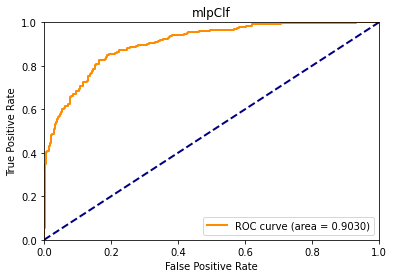

In [18]:
y_score = mlpClf.predict_proba(valid_vectors_dbow)[:,1]
# Roc Curve for validation data 
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_valid, y_score)
roc_auc = auc(fpr, tpr) 

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.4f)'% roc_auc)

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('mlpClf')
plt.legend(loc="lower right")
plt.show()

In [19]:
# save MLP predictions
np.save("../working/y_scoremlpClf",y_score)